## Perceptron learning

In the first part of this exercise we will reproduce the Figures in Chapter 39 of the MacKay book.

$x$ is an $p \times N$ matrix containing all the N-dimensional input vectors for each of the p patterns. We set $N=2$ and use an explicit threshold b in the perceptron activation; w[0] and w[1] are the weights.

$z$ is a vector of length p containing the targets for each training pattern, each target $\in$ {0,1}. In class we used the notation: $z^\mu$ and $x^\mu_i$.

We can choose two options: linearly separable patterns, or nonseparable patterns

In [70]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)

## Generate training set

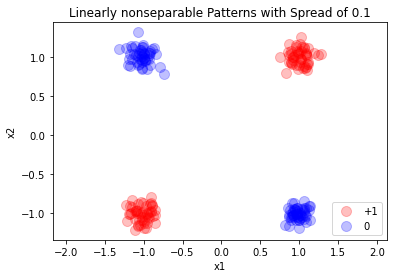

In [106]:
def generate_patterns(spread,N=2,p1=100,p2=100,option='separable',plot=False):
    # spread parameter is the standard deviation of the the patterns around each center of the gaussian distribution
    # generate targets
    
    z=np.ones((p1+p2))# targets
    z[p1:]=0 # t2=0 targets
    x=np.zeros((p1+p2,N))
    
    # generate inputs
    if option=='separable':
        # separable targets
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
    elif option=='nonseparable':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]
    elif option=='weird':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]+1.5
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]+1
        z=np.ones((p1+p2))# targets
        z[0:int(p1/2)]=0; z[p1:int(p1+p2/2)]=0

    # make a figure
    if plot == True:
        fig,ax=plt.subplots()
        plt.title('Linearly {} Patterns with Spread of {}'.format(option,spread))
        size=100
        # scatterplot
        ax.scatter(x[z==1,0],x[z==1,1],s=size,color='red',alpha=0.25,label='+1')
        ax.scatter(x[z==0,0],x[z==0,1],s=size,color='blue',alpha=0.25,label='0')
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax.legend(loc='lower right')
        ax.axis('equal')  
    return x,z

p1=100
p2=100
x,z=generate_patterns(spread=0.1,N=2,p1=p1,p2=p2,option='nonseparable',plot=True)

## Activity rule and cost function
Activity: 
$$
f(h)={1\over 1+e^{-h}}
$$

Log-likelihood function: 
$$
G(z^\mu|x^\mu_i,w_i)=-\sum_{\mu=1}^p\left[z^\mu\ln f(h^\mu)+(1-z^\mu)\ln(1- f(h^\mu))\right]\ , \,\,h^\mu=\sum_{i=1}^Nw_ix_i^\mu+b
$$
Note: in class $b=-w_0$.

Log-posterior: 
$$
M(w_i|z^\mu,x^\mu_i)=G(z^\mu|x^\mu_i,w_i)+{1\over2}\alpha \sum_{i=1}^Nw_i^2
$$

In [107]:
# activity rule
def sigmoid(h,derivative=False):
          # input h=sum_i w_i x_i
          b=-1; # threshold or bias
          h1=h+b # total activation
          out=1/(1+np.exp(-h1)) # activity
          return out*(1-out) if derivative else out
          

# log-likelihood

def Gfunc(ww,xx,zz):
          # log likelihood (just the part that depends on the weights)
          # ww=weights, xx=datapoints, zz=class labels
          ff=sigmoid(xx.dot(ww))
          inf_ff=~np.isinf(np.log(ff))
          # inf_ffm=~np.isinf(np.log(1-ff))
          inf_ffm=~((1-ff)==0)
          out=-zz[inf_ff].dot(np.log(ff[inf_ff]))-(1-zz[inf_ffm]).dot(np.log(1-ff[inf_ffm]))
          return out

## Batch training using the perceptron learning rule
$$
\Delta w_i=w^{new}_i-w^{old}_i=\eta\left(\sum_{\mu=1}^p\left[z^\mu-f(h^\mu)\right]x_i^\mu-\alpha w_i\right)
$$

In [108]:
T=100000# number of training steps
stepPlot=T/100 # snapshot of learning

N=2
# initialize the weights
w0=(1/N**(1/2))*np.random.randn(N)
print('initial weights %s' % w0)
# learning rate
eta=0.001
# weight decay
alpha=0.1

# training 
EarlyStopping=False
Gplot=[]; Mplot=[]; wplot=[]; yplot=[]; errorPlot=[]; step_xplot=[]
for step in range(T):
          if step==0: w=w0
          h=x.dot(w) # activation (beware of the bias)
          y=sigmoid(h) # output
          err=z-y # error
          gr=-err.dot(x)
          w=w-eta*(gr+alpha*w) # update rule
          if step % stepPlot==0:
                    step_xplot.append(step)
                    gtemp=Gfunc(w,x,z) # log-likelihood
                    Gplot.append(gtemp)
                    Mplot.append(gtemp+0.5*alpha*w.dot(w))
                    wplot.append(w)
                    yplot.append(y)
                    errorfrac=sum(np.abs(np.round(yplot[-1]-z)))/len(z)
                    errorPlot.append(errorfrac)
                    if EarlyStopping==True:
                              if len(errorPlot)>5:
                                        if np.std(errorPlot[-10:])==0:
                                                  break
                              # if errorfrac==0: break # if the classification is perfect, we stop training
          if step % (stepPlot*10)==0:
                    print('{a1} steps, G:{a2:.6e}, M:{a5:.6e}, errorfrac: {a6}, weights:{a3:.4},{a4:.4}'.format(a1=step+1,a2=gtemp,a3=w[0],a4=w[1],a5=gtemp+0.5*alpha*w.dot(w),a6=errorfrac))
print('{a1} steps, G:{a2:.6e}, M:{a5:.6e}, errorfrac: {a6}, weights:{a3:.4},{a4:.4}'.format(a1=step+1,a2=gtemp,a3=w[0],a4=w[1],a5=gtemp+0.5*alpha*w.dot(w),a6=errorfrac))


initial weights [-0.75089314  0.59837258]
1 steps, G:1.797174e+02, M:1.797600e+02, errorfrac: 0.75, weights:-0.7219,0.5752
10001 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003651,-0.008506
20001 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003651,-0.008506
30001 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003651,-0.008506
40001 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003651,-0.008506
50001 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003651,-0.008506
60001 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003651,-0.008506
70001 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003651,-0.008506
80001 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003651,-0.008506
90001 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003651,-0.008506
100000 steps, G:1.626509e+02, M:1.626509e+02, errorfrac: 0.5, weights:0.0003


## Plot learning schedule

Plot classification probability $P=0.25,0.75$ using the activity rule (P is the output of the perceptron): $h=\log[P/(1-P)]$

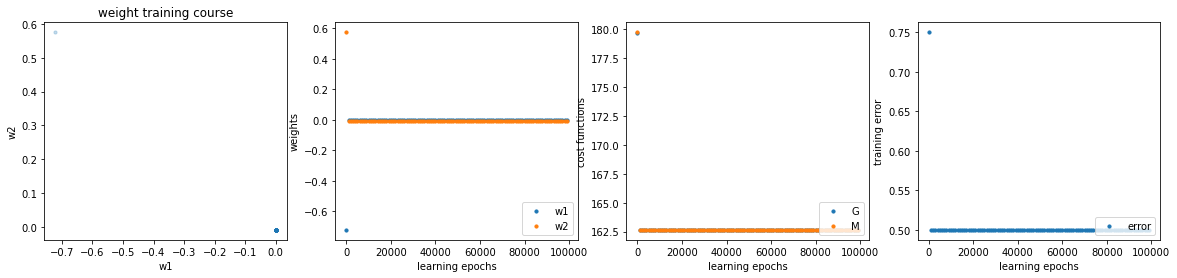

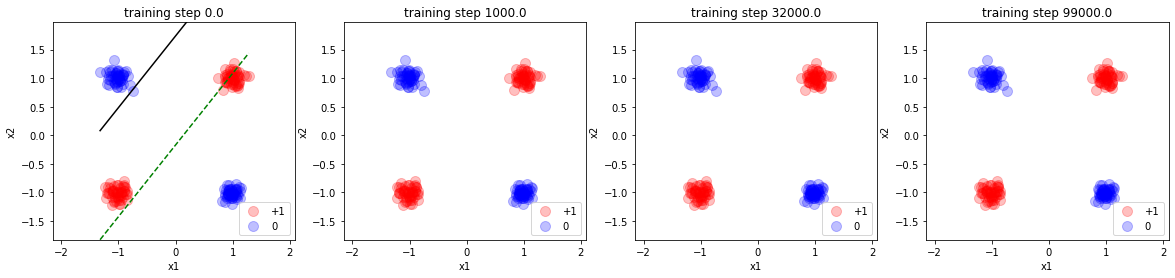

In [109]:

b=-1 # this is the bias in the perceptron sigmoid activity rule
# plot evolution of the weights
fig,ax=plt.subplots(1,4,figsize=(20,4))
wplot1=np.array(wplot)
# xplot=stepPlot*(np.arange(np.int(T/stepPlot))+1)
xplot=step_xplot
ax[0].scatter(wplot1[:,0],wplot1[:,1],s=10,alpha=0.25)
ax[0].set_xlabel('w1'); ax[0].set_ylabel('w2'); ax[0].set_title('weight training course')
for i in range(N):
    ax[1].scatter(xplot,wplot1[:,i],s=10,label='w%s' % (i+1))
    ax[1].legend(loc='lower right'); ax[1].set_xlabel('learning epochs'); ax[1].set_ylabel('weights'); #ax[1].set_xscale('log'
# plot cost functions
ax[2].scatter(xplot,np.array(Gplot),s=10,label='G')
ax[2].scatter(xplot,np.array(Mplot),s=10,label='M')
ax[2].legend(loc='lower right'); ax[2].set_xlabel('learning epochs'); ax[2].set_ylabel('cost functions'); #ax[1].set_xscale('log')
# plot error rate on the training set
ax[3].scatter(xplot,np.array(errorPlot),s=10,label='error')
ax[3].legend(loc='lower right'); ax[3].set_xlabel('learning epochs'); ax[3].set_ylabel('training error'); #ax[1].set_xscale('log')
# plt.savefig('figs/CLASS0_WeightTraining_Alpha' + '{}.pdf'.format(alpha), bbox_inches='tight')

# plot evolution of the classification boundary
fig,ax=plt.subplots(1,4,figsize=(20,4))
step=[0,1,int(np.round(wplot1.shape[0]/3))-1,int(np.round(wplot1.shape[0]))-1]
h25=np.log(0.25/(1-0.25)) # activation corresponding to 0.25 probability of t=1
h75=np.log(0.75/(1-0.75))# activation corresponding to 0.75 probability of t=1

for i in range(len(step)):
    size=100
    ax[i].scatter(x[z==1,0],x[z==1,1],s=size,color='red',alpha=0.25,label='+1')
    ax[i].scatter(x[z==0,0],x[z==0,1],s=size,color='blue',alpha=0.25,label='0')
    ax[i].set_xlabel("x1"); ax[i].set_ylabel("x2")
    ax[i].legend(loc='lower right')
    ax[i].axis('equal')
    x1=np.linspace(x[:,0].min(),x[:,0].max(),num=100)
    y0=(-b-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=0 activation
    y1=(-b-h25-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=+1 activation
    ym1=(-b-h75-wplot1[step[i],0]*x1)/wplot1[step[i],1]   #h=-1 activation
    ax[i].plot(x1,y0,'k'); ax[i].plot(x1,y1,'--b'); ax[i].plot(x1,ym1,'--g');
    ax[i].set_title("training step %s" % (step[i]*stepPlot))
    ax[i].set_xlim(1.5*x1[0],1.5*x1[-1]); ax[i].set_ylim(1.5*x[:,1].min(),1.5*x[:,1].max());


## Learning as inference

In the second part of this exercise we will reproduce the Figures in Chapter 41 of the MacKay book.

Plot the log-likelihood $G(z^\mu|w_i|,x^\mu_i)$ and the log-posterior $M(w_i|z^\mu,x^\mu_i)$ as functions of the weights, for fixed training data $(z^\mu,x^\mu_i)$

array([ 55, 132,   1,  18, 107,  62, 164, 165,   7, 171, 155, 182,  43,
       176,  96, 112,  68,   4, 134,  91,  63, 199,  13, 117,  97, 114,
         6,  22,  77,  75, 101, 188,  36,  28,  19, 119, 109, 108,  32,
       105,  82,  14, 189, 169,  45,  46,  31,  66,  93,   0, 144, 193,
       151, 194, 102,  81, 126,  26, 161, 143, 127, 136,  76, 135, 197,
       103,  37, 124, 123,  54,  33,  44, 167, 140,  41,  65, 145,  30,
         2,  39,  79, 162, 110,   3,  67,  99,  56, 142, 104, 147,  48,
        58,  98, 149,  16, 133,  12,  73,  84, 174,  35, 125, 192,   5,
       116,  95,  74, 181, 183, 170,  50,  83,  29, 158,  60, 186,  47,
       152, 173,  85, 184, 163,  11,  15,  27, 154,  61,  23,   8, 160,
       168, 130,  70, 100, 175, 191, 180, 179, 187, 106,  86, 120,  71,
       146,  78, 113, 156,  21, 139, 178,  20,  24, 190, 198, 177, 150,
        87,  72, 153,  40, 138, 159, 118, 172,  10, 129, 122, 148,  90,
       157,  69,  89, 195,  53,  51,  57,  25, 166,   9, 115,  4

In [110]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter, LogLocator

# size of the training set
ntrain=np.min([10,p1,p2])
indtrain=np.concatenate([np.arange(ntrain),p1+np.arange(ntrain)])
inpermute=np.random.permutation(p1+p2)
xplot=x[inpermute[indtrain]]
zplot=z[inpermute[indtrain]]

# create a 2d grid of (w1,w2)
Wmax=50
W1vec=np.arange(-Wmax,Wmax,0.1)
W2vec=np.arange(-Wmax,Wmax,0.1)
W1,W2=np.meshgrid(W1vec,W2vec)
len1,len2=W1.shape
Ginference=np.zeros((len1,len2)) # loglikelihood
Minference=np.zeros((len1,len2)) # logposterior
Priorinference=np.zeros((len1,len2)) # logprior

# calculate observables on the grid
for i1 in range(len1):
          for i2 in range(len2):
                    wtemp=np.array([W1[i1,i2],W2[i1,i2]])
                    Ginference[i1,i2]=Gfunc(wtemp,xplot,zplot)
                    Priorinference[i1,i2]=0.5*alpha*wtemp.dot(wtemp)
                    Minference[i1,i2]=Ginference[i1,i2]+Priorinference[i1,i2]
        
LLplot=-Ginference
Mplot=-Minference
Priorplot=-Priorinference
# MAP estimate of the weights
wmapind=np.where(Mplot==Mplot.max())
print(wmapind)
print('w_MAP: w1={a1}, w2={a2}'.format(a1=W1[wmapind],a2=W2[wmapind]))

(array([498]), array([497]))
w_MAP: w1=[-0.3], w2=[-0.2]


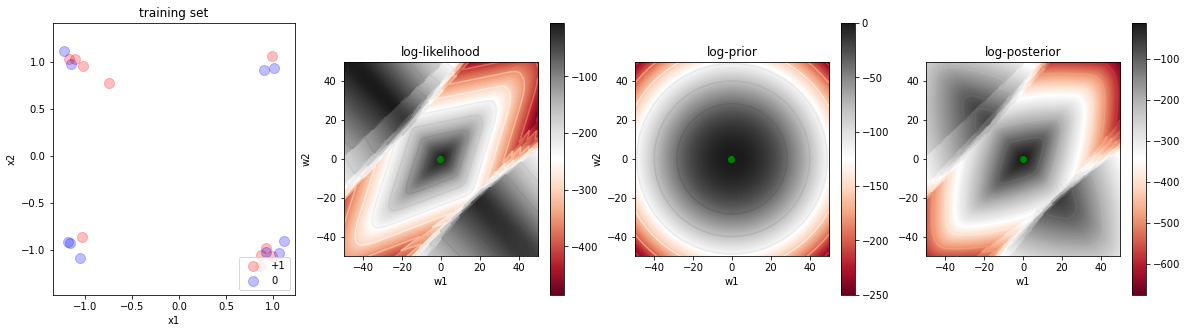

In [112]:
#=========
# PLOTS
#=========
# plot the surface
fig,ax=plt.subplots(1,4,figsize=(20,5))

# training set
size=100
# scatterplot
ax[0].scatter(xplot[0:ntrain,0],xplot[0:ntrain,1],s=size,color='red',alpha=0.25,label='+1')
ax[0].scatter(xplot[ntrain:,0],xplot[ntrain:,1],s=size,color='blue',alpha=0.25,label='0')
ax[0].set_xlabel("x1"); ax[0].set_ylabel("x2"); ax[0].set_title("training set")
ax[0].legend(loc='lower right')
ax[0].axis('equal')

# plot log-likelihood
surf1=ax[1].imshow(LLplot,origin='lower',cmap='RdGy',extent=[np.min(W1),np.max(W1),np.min(W2),np.max(W2)])
ax[1].contour(W1,W2,LLplot,cmap='RdGy')
fig.colorbar(surf1,ax=ax[1])
ax[1].set_title('log-likelihood'); ax[1].set_xlabel('w1'); ax[1].set_ylabel('w2')
ax[1].scatter(W1[wmapind],W2[wmapind],color='g')

# plot log-prior
surf3=ax[2].imshow(Priorplot,origin='lower',cmap='RdGy',extent=[np.min(W1),np.max(W1),np.min(W2),np.max(W2)])
ax[2].contour(W1,W2,Priorplot,cmap='RdGy')
fig.colorbar(surf3,ax=ax[2])
ax[2].set_title('log-prior'); ax[2].set_xlabel('w1'); ax[2].set_ylabel('w2')
ax[2].scatter(W1[wmapind],W2[wmapind],color='g')

# plot log-posterior
surf2=ax[3].imshow(Mplot,origin='lower',cmap='RdGy',extent=[np.min(W1),np.max(W1),np.min(W2),np.max(W2)])
ax[3].contour(W1,W2,Mplot,cmap='RdGy')
fig.colorbar(surf2,ax=ax[3])
ax[3].set_title('log-posterior'); ax[3].set_xlabel('w1'); ax[2].set_ylabel('w2')
ax[3].scatter(W1[wmapind],W2[wmapind],color='g')